# Problem Set 1 (PS1): Pathological K-means example
The lecture introduced the [K-means clustering technique](https://en.wikipedia.org/wiki/K-means_clustering) as part of our unsupervised learning discussion. The [K-means approach](https://en.wikipedia.org/wiki/K-means_clustering) is straightforward and, in some ways, intuitive, but it has several limitations, such as the necessity to specify the number of clusters in advance. Additionally, there are more significant concerns, such as the inability to cluster overlapping datasets (or non-convex datasets). 

### Problem
There was the following pathological example given [in the MAT 180 Big Data course at UC Davis](https://www.math.ucdavis.edu/~strohmer/courses/180BigData/180coursematerial.html) that was not explored in detail. In this example, we have (potentially) overlapping data clusters.
* __Example__: Consider two circles, each of radius 1, and their centers are a distance $d$ apart. As long as $d > 2.08$, K-means yields the correct answer. But if $d\leq{2.08}$, K-means fails. This is the failure of K-means and not of Lloyd's algorithm. Let's explore this example in PS1.

## Setup, Prerequisites and Data
We set up the computational environment by including the `Include.jl` file and then load any needed resources, e.g., a sample dataset, to cluster, and we end by setting up any required constants. The `Include.jl` file loads external packages, various functions that we will use in the exercise, and custom types to model the components of our problem.

In [261]:
include("Include.jl");

Let's set some constants and colors.

Finally, let's set up the color dictionary for the visualizations in the lecture. The keys of the `my_color_dictionary::Dict{Int64,RGB}` dictionary are the cluster indexes, while the values are the colors mapped to that index.

In [264]:
number_label_one = 500;
number_label_two = 500;
total_number_of_points = (number_label_one + number_label_two);
number_of_features = 2; # features: (x,y)
c₁ = (1.0,1.0); # center for cluster 1
 c₂ = (2.0, 1.0); # center for cluster 2
maxiter = 20000; # maximum iterations of our K-means
K = 3; # number of clusters. Why do we pick 5?
ϵ = 1e-6; # tolerance for termination. We can set this to whatever we want

In [265]:
my_color_dictionary = Dict{Int64,RGB}();
my_color_dictionary[1] = colorant"#03045e";
my_color_dictionary[2] = colorant"#e36414";
my_color_dictionary[3] = colorant"#00b4d8";

## Task 1: Not sure
Fill me in

In [267]:
D = let

    # initialize -
    D = Array{Float64,2}(undef, total_number_of_points, number_of_features);
    s₁ = generatedata(c₁, number_of_points = number_label_one); # generate label 1 data
    s₂ = generatedata(c₂, number_of_points = number_label_two); # generate label 2 data

    # mix s₁, s₂ together (randomly)
    tmp = vcat(s₁,s₂)
    random_perm_index_vector = randperm(total_number_of_points);
    for i ∈ eachindex(random_perm_index_vector)
        k = random_perm_index_vector[i]; # get the from col -
        for j ∈ 1:number_of_features
            D[i,j] = tmp[k,j];
        end
    end
    
    D
end;

Check:

In [269]:
distance = let
    d = Euclidean();
    d(c₁,c₂)
end

1.0

### Visualize initial data
`Unhide` the code block below to see how we plotted the dataset using [the `Plots.jl` package](https://github.com/JuliaPlots/Plots.jl), and particularly the [`scatter(...)` function](https://docs.juliaplots.org/stable/api/#Plots.scatter-Tuple). An initial look at the data (`income` versus `spendingscore`) suggests that there are perhaps at least five groups (clusters) in the data. However, the groupings in other views, e.g., `age` versus `spending score,` are not as apparent.

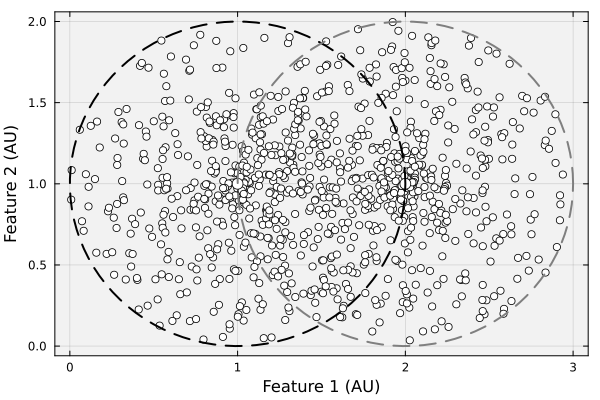

In [301]:
let

    dataset = D; # what dataset am I looking at?
    horizontal_index = 1;
    vertical_index = 2;
    p = plot(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent); # make an empty plot
    
    circle_one = fixedcircle(c₁);
    circle_two = fixedcircle(c₂);
    
    scatter!(dataset[:, horizontal_index], dataset[:, vertical_index], label="", mec=:navy, c=:white)
    scatter!([c₁[1]], [c₁[2]], ms=6, mec=:navy, c=:white, label="")
    scatter!([c₂[1]], [c₂[2]], ms=6, mec=:navy, c=:white, label="")
    plot!(circle_one[:,1], circle_one[:,2], lw=2, c=:black, ls=:dash, label="")
    plot!(circle_two[:,1], circle_two[:,2], lw=2, c=:gray50, ls=:dash, label="")
    

    xlabel!("Feature 1 (AU)", fontsize=18);
    ylabel!("Feature 2 (AU)", fontsize=18);
end

## Task 2: Cluster the data
Fill me in

The `model::MyNaiveKMeansClusteringAlgorithm` contains the data that we passed in and _two derived (computed) fields_ that we computed in [the `build(...)` method](src/Factory.jl):
* The `centroids::Dict{Int64, Vector{Float64}}` dictionary holds the centroid values $\mu_{1},\dots,\mu_{K}$ for each cluster. The dictionary's keys are the cluster index, while the values are the `m`-dimensional centroids (means) of the data points in that cluster. We initialize the centroids randomly.
* The `assignments::Vector{Int64}` field is an `n`-dimensional vector holding the cluster index that each data point is assigned to. We initialize the assignments randomly.

In [274]:
model = build(MyNaiveKMeansClusteringAlgorithm, (
        maxiter = maxiter,
        dimension = number_of_features,
        number_of_points = total_number_of_points,
        K = K,
        ϵ = ϵ,
        dataset = D,
));

#### Visualize the initial centroids and assignments
`Unhide` the code block below to see how we plotted the initial assignments and centroids. Each data point, i.e., feature vector (shown by the circles), is initially assigned to a random cluster, and the centroids dictionary is initialized randomly, where the centroids are shown as `+.`
* Depending upon the scale factor, the initial centroid values will be on the lower left of the plot. The features will be randomly dispersed throughout the plane. The centroids' positions and the features' classification will be updated with each iteration of the k-means algorithm.

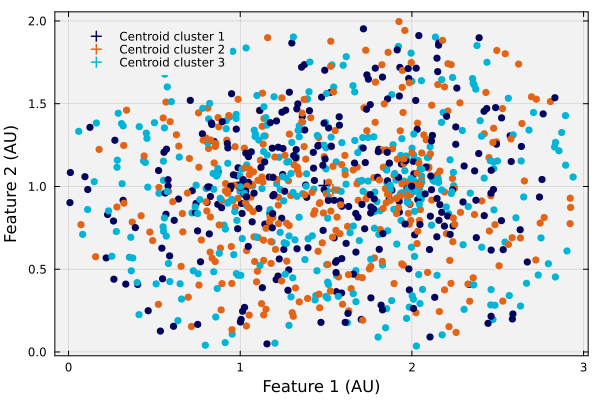

In [276]:
let

    dataset = D; # what dataset am I looking at?
    horizontal_index = 1;
    vertical_index = 2;
    p = plot(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent); # make an empty plot
   
    assignments = copy(model.assignments);
    for i ∈ eachindex(assignments);
        a = assignments[i];        
        scatter!([dataset[i, horizontal_index]], [dataset[i, vertical_index]], label="", c=my_color_dictionary[a], msc=my_color_dictionary[a]);
    end
    current();

    # plot the centroids -
    centroids = copy(model.centroids);
    for k ∈ 1:K
        c = centroids[k]
        scatter!([c[horizontal_index]], [c[vertical_index]], label="Centroid cluster $(k)", msc=my_color_dictionary[k], c=my_color_dictionary[k], 
            ms=6, markerstrokewidth=2, markershape = :plus)
    end
    current();

    xlabel!("Feature 1 (AU)", fontsize=18);
    ylabel!("Feature 2 (AU)", fontsize=18);
end

### Execute the Clustering
We'll call [the `cluster(...)` method](src/Cluster.jl) to refine our initial random cluster assignments and centroid values. The [`cluster(...)` method](src/Cluster.jl) takes a few arguments (and returns the clustering results):

* __Data__: `D::Array{<:Number, 2}`: The first argument is the data matrix `D::Array{<:Number,2}` which we want to cluster. The data matrix has the feature vectors $\mathbf{x}\in\mathbb{R}^{m}$ as columns. Its values can be any subtype [of Number](https://docs.julialang.org/en/v1/base/numbers/#Core.Number). 
* __Model__: `model::<: MyAbstractUnsupervisedClusteringAlgorithm`: The second argument is the cluster model instance, i.e.,  the `model::MyNaiveKMeansClusteringAlgorithm` instance that we built above. However, the model can be any subtype of ` MyAbstractUnsupervisedClusteringAlgorithm.`
    * __Why an abstract generic type?__ Suppose we have different K-means implementations or different clustering logic altogether. In that case, we can take advantage of Julia's multiple dispatch functionality by passing in a different clustering model. This provides a single method for a user to call, which calls a different implementation.
* __Verbose (optional)__: `verbose::Bool`: The `verbose::Bool` argument tells our implementation whether to save data from each algorithm iteration. The default value is `false`. However, if the value is set to `true,` a save file holding the assignments, centroids, and loop index is written at each iteration.
* __Measure (optional)__:`d::Any`. The optional distance argument is the $d(p,q)$ function and can be used to change how the similarity between feature vectors $\mathbf{x}\in\mathcal{D}$ is calculated. We can use [any metrics exported by the `Distances.jl` package](https://github.com/JuliaStats/Distances.jl); by default, we [use the Euclidian distance](https://en.wikipedia.org/wiki/Euclidean_distance). 

The [`cluster(...)` method](src/Cluster.jl) returns cluster centroids, the assignments, and the number of iterations that it took to reach the final assignment in the `results::NamedTuple.`

In [278]:
result = cluster(D, model, verbose = false); # cluster the data

Fill me in

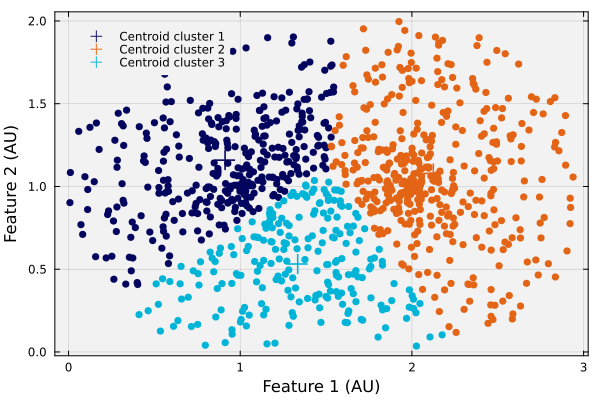

In [280]:
let

    dataset = D;
    horizontal_index = 1;
    vertical_index = 2;
    p = plot(bg="gray95", background_color_outside="white", framestyle = :box, fg_legend = :transparent); # make an empty plot
    
    assignments = result.assignments;
    for i ∈ eachindex(assignments);
        a = assignments[i];        
        scatter!([dataset[i, horizontal_index]], [dataset[i, vertical_index]], label="", c=my_color_dictionary[a], msc=my_color_dictionary[a]);
    end
    current();

    # plot the centroids -
    centroids = result.centroids;
    for k ∈ 1:K
        c = centroids[k]
        scatter!([c[horizontal_index]], [c[vertical_index]], label="Centroid cluster $(k)", msc=my_color_dictionary[k], c=my_color_dictionary[k], 
            ms=10, markerstrokewidth=2, markershape = :plus)
    end
    current();

    xlabel!("Feature 1 (AU)", fontsize=18);
    ylabel!("Feature 2 (AU)", fontsize=18);
end

## Task 3: Compute the quality of the clusters
The silhouette method assesses data consistency within clusters. The silhouette score ranges from -1 to 1, and a high score indicates that a data point is well-suited to its cluster and poorly suited to neighboring clusters. The clustering configuration is likely appropriate when most objects have a high silhouette score. Conversely, the clustering configuration may have too many clusters if many points display a low or negative value.

Assume that we have clustered the data using K-means into $K$ clusters $\mathcal{C} = \{c_1, c_2, \ldots, c_K\}$.
Then, for a data point $\mathbf{x}_i\in c_i$, let $a(i)$ denote the average distance between $\mathbf{x}_i$ and all other points in the same cluster $c_i$:
$$
\begin{equation}
a(i) = \frac{1}{|c_i| - 1}\sum_{j\in c_i, j\neq i}d(i,j)
\end{equation}
$$
where $|c_i|$ denotes the number of data points in cluster $c_i$, and $d(i,j)$ denotes the distance between data points $\mathbf{x}_i\in{c_{i}}$ and $\mathbf{x}_j\in{c_{i}}$.
Next, we define $b(i)$, the mean dissimilarity of $\mathbf{x}_i$ to all other points not in the same cluster $c_i$:
$$
\begin{equation}
b(i) = \min_{j\neq i}\frac{1}{|c_j|}\sum_{j\in c_j}d(i,j)
\end{equation}
$$
Putting it all together, the silhouette score $s(i)$ for data point $\mathbf{x}_i$ is defined as:
$$
\begin{equation}
s(i) = \frac{b(i) - a(i)}{\max\{a(i), b(i)\}}\quad\text{if}|c_i|>1
\end{equation}
$$
If $|c_i|=1$, then $s(i)=0$. This gives a silhouette score for each data point as:
$$
\begin{equation}
   s(i) =
   \begin{cases}
      1 - a(i)/b(i) & \text{if } a(i) < b(i)\\ 
      0 & \text{if } a(i) = b(i)\\
      b(i)/a(i) - 1 & \text{if } a(i) > b(i)
   \end{cases}
\end{equation}
$$
This definition shows $-1\leq s(i)\leq 1$. 
The mean $s(i)$ of all data points in a cluster measures how tightly grouped the points in the cluster are.
Thus, the mean of $s(i)$ over all data in the entire dataset measures how appropriately the data have been clustered.
If there are too many or too few clusters, as may occur when a poor choice of $K$ is made, some clusters will typically display much narrower silhouettes than the rest. 
Thus, silhouette plots and means may be used to visualize a dataset's natural number of clusters.

In [282]:
s, s̄ = let

    a = result.assignments;
    s = silhouette(D,a);
    s̄ = mean(s)

    s,s̄
end

([0.519724082717466, 0.12293528257080846, 0.5341867862594258, 0.3451415458095909, 0.3652435568981375, 0.3870721245901824, 0.3445480359014965, 0.12796322999121731, 0.439973840000076, 0.5289114395055888  …  0.47319586567175015, 0.28109674010496827, 0.37844879865576164, 0.2015622203693057, 0.4258839730847426, 0.2630558793445378, 0.34659030714486505, 0.46961286122292906, 0.484840252380818, 0.46292684741830853], 0.3612326932532726)